In [1]:
# --------------------------------------------------------------------
# Importing required libraries
# --------------------------------------------------------------------
import random
import numpy as np
import pandas as pd
import PIL.Image as Image
from glob import glob
from mymodels import (
    ReconNet,
    VisionTransformerTimeSeriesFormalizedWithSARCLS,
    Classifier,
)
from mymodels.unet import Unet
from mymodels.discriminatorv2 import Discriminator
import matplotlib.pyplot as plt
from myutils import imshow
from datetime import datetime

# importing pytorch functions
import torch
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tvtransforms
from torch.nn import SmoothL1Loss, BCELoss

# importing utils required in th code
from utils import subsample
from utils import transforms
from utils.evaluate import ssim, psnr, nmse
from utils.losses import (
    SSIMLoss,
    SSIMLoss_V1,
    MultiScaleLoss,
    spectral_angle_mapper_numpy,
    peak_signal_to_noise_ratio,
    structural_similarity_index,
    CrossEntropyWithNaNMask,
)
from utils.process import transform_tensor_image, RealisticCloudMaskFunc
from osgeo import gdal
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_squared_error
import math

# Device
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cuda'
# np.random.seed(42)
# random.seed(42)

print("******* STARTED AT ************", datetime.now())

/home/snt/miniconda3/envs/causal_vit_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/snt/miniconda3/envs/causal_vit_env/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/snt/miniconda3/envs/causal_vit_env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


******* STARTED AT ************ 2025-01-07 22:49:42.515283


## Initialization 

In [2]:
class ImagenetDataset(Dataset):
    def __init__(
        self,
        if_SAR=True,
        isval=False,
        add_cloud_mask=True,
        add_kspace_mask=False,
        add_random_time_mask=False,
        val_path="/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/val",
        train_path="/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train",
    ):

        self.add_cloud_mask = add_cloud_mask
        self.add_kspace_mask = add_kspace_mask
        self.add_random_time_mask = add_random_time_mask
        self.if_SAR = if_SAR
        self.val_path = val_path
        self.train_path = train_path
        if isval:
            ## combine paths of each imagenet validation image into a single list
            self.files = []
            pattern = "*.tif"
            for dir, _, _ in os.walk(self.val_path):
                self.files.extend(glob(os.path.join(dir, pattern)))
        else:
            ## combine paths of each imagenet training image into a single list
            self.files = []  # get path of each imagenet images
            pattern = "*.tif"
            for dir, _, _ in os.walk(self.train_path):
                self.files.extend(glob(os.path.join(dir, pattern)))

        self.transform = transform_tensor_image
        self.factors = [2, 3, 4, 5, 6, 7, 8, 9, 10]

    def read_tiff(self, file_path):
        dataset = gdal.Open(file_path)
        if not dataset:
            raise FileNotFoundError(f"Unable to open the file: {file_path}")
        band_count = dataset.RasterCount
        bands_data = []
        for i in range(1, band_count + 1):
            band = dataset.GetRasterBand(i)
            band_name = band.GetDescription()
            band_data = band.ReadAsArray()
            bands_data.append(band_data)

        image = np.stack(bands_data, axis=0)
        return image

    def get_mask_func(
        self,
        samp_style,
        factor,
    ):
        center_fractions = 0.08 * 4 / factor
        if samp_style == "random":
            mask_func = subsample.RandomMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        elif samp_style == "equidist":
            mask_func = subsample.EquispacedMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        return mask_func

    def add_gaussian_noise(self, x):
        ch, row, col = x.shape
        mean = 0
        var = 0.05
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (ch, row, col))
        gauss = gauss.reshape(ch, row, col)
        noisy = x + gauss
        return noisy.float()

    def __len__(
        self,
    ):
        return len(self.files)

    def __getitem__(self, idx):
        if self.if_SAR:
            channel_count = 13
        else:
            channel_count = 11
        tiff = torch.from_numpy(self.read_tiff(self.files[idx]))
        # tiff = self.transform(tiff, target_size=64 * 3, crop_size=60 * 3)  # If classification, remove this data augmentation transforme
        channels, height, width = tiff.shape
        time_span = int((channels - 1) / channel_count)
        images = np.split(
            tiff, [(channel_count) * (i + 1) for i in range(time_span)], axis=0
        )
        original_spaces_transformed = []
        masked_spaces = []
        cloud_masks = []
        added_cloud_masks = []

        random_index = random.randint(0, len(images) - 2)
        for i in range(len(images) - 1):
            y = images[i]
            cloud_mask = torch.isnan(y).any(dim=0)
            cloud_mask = (~cloud_mask).int()
            y[:, cloud_mask == 0] = 0
            original_spaces_transformed.append(y.clone())
            masked_kspace = y.clone()

            if random.uniform(0, 1) < 0.5:
                y = torch.rot90(y, 1, [-2, -1])

            if random.uniform(0, 1) < 0.5:
                samp_style = "random"
            else:
                samp_style = "equidist"

            # factor = random.choice(self.factors)
            mask_func = self.get_mask_func(samp_style, factor=2.0)

            if self.add_kspace_mask:  # add kspace mask
                masked_kspace, _ = transforms.apply_mask(masked_kspace, mask_func)
            if self.add_cloud_mask:  # add cloud mask
                masked_kspace, added_cloud_mask = RealisticCloudMaskFunc(masked_kspace)
                added_cloud_masks.append(added_cloud_mask.unsqueeze(0))
            else:
                added_cloud_masks.append(torch.ones_like(cloud_mask.unsqueeze(0)))
            if self.add_random_time_mask:  # add time loss mask
                if i == random_index:
                    masked_kspace = masked_kspace.zero_()

            masked_spaces.append(masked_kspace)
            cloud_masks.append(cloud_mask.unsqueeze(0))

        cls_targets = np.squeeze(images[-1])
        unique_classes = torch.unique(cls_targets[~torch.isnan(cls_targets)])
        num_class = len(unique_classes)

        cls_targets = torch.nan_to_num(cls_targets, nan=num_class)
        cls_targets = cls_targets.long()

        # masked_kspace = self.add_gaussian_noise(y)
        masked_space_concat = torch.cat(masked_spaces, dim=0)
        original_spaces_transformed_concat = torch.cat(
            original_spaces_transformed, dim=0
        )
        cloud_mask_concat = torch.cat(cloud_masks, dim=0)
        added_cloud_masks_concat = torch.cat(added_cloud_masks, dim=0)
        return (
            masked_space_concat,  # inputs
            original_spaces_transformed_concat,  # tragets
            cloud_mask_concat,
            added_cloud_masks_concat,
            cls_targets,
        )


train_dataset = ImagenetDataset(
    if_SAR=True,
    isval=False,
    add_cloud_mask=True,
    add_kspace_mask=True,
    add_random_time_mask=False,
)
val_dataset = ImagenetDataset(
    if_SAR=True,
    isval=True,
    add_cloud_mask=True,
    add_kspace_mask=True,
    add_random_time_mask=False,
)

batch_size = 30
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# ntrain = 20
# train_dataset, _ = torch.utils.data.random_split(
#     train_dataset,
#     [ntrain, len(train_dataset) - ntrain],
#     generator=torch.Generator().manual_seed(42),
# )

trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=2,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)
valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=1,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)

Test the mask and future application

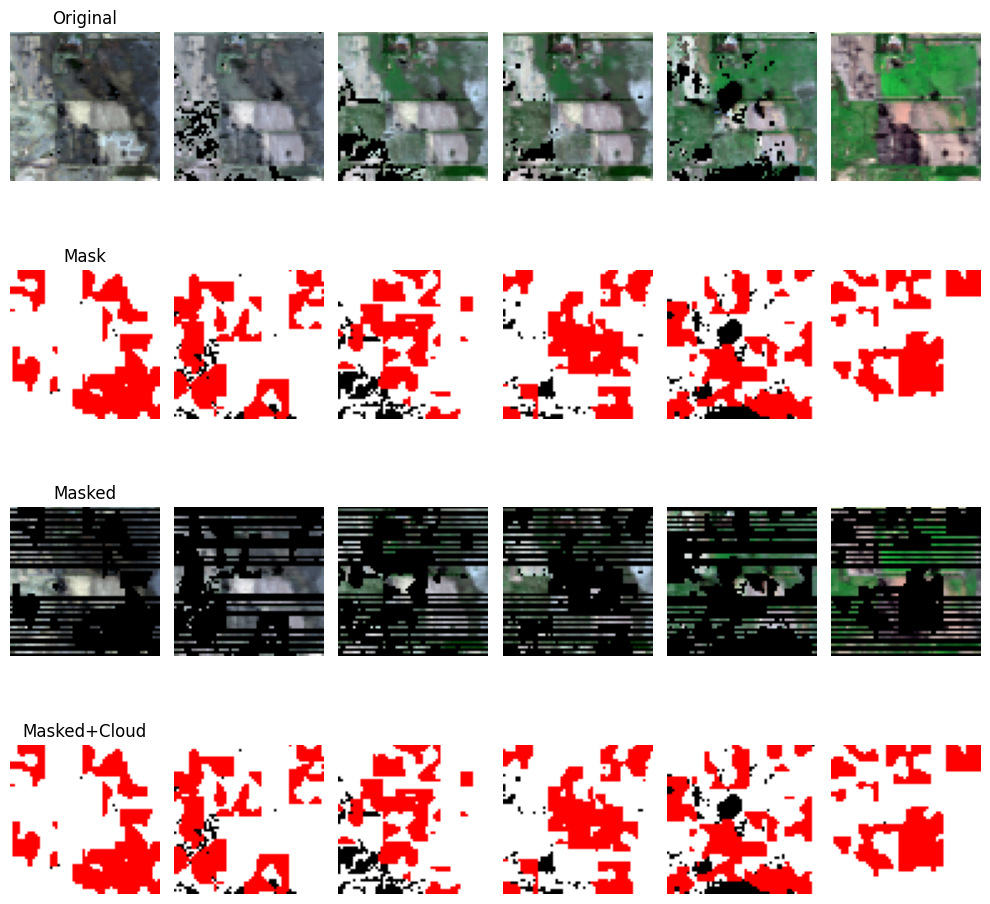

In [3]:
def read_tiff(file_path):
    dataset = gdal.Open(file_path)
    if not dataset:
        raise FileNotFoundError(f"Unable to open the file: {file_path}")
    band_count = dataset.RasterCount
    bands_data = []
    for i in range(1, band_count + 1):
        band = dataset.GetRasterBand(i)
        band_name = band.GetDescription()
        band_data = band.ReadAsArray()
        bands_data.append(band_data)

    image = np.stack(bands_data, axis=0)
    return image


def create_time_series_pseudo_color_image(
    multi_channel_array, cloud_mask, added_cloud_mask
):
    channel_count = 13
    if len(multi_channel_array.shape) != 3:
        raise ValueError("Input Array Shold be H W C")
    channel_list = [3, 2, 1]
    channels, h, w = multi_channel_array.shape
    time_span = int((channels - 1) / channel_count)
    images = np.split(
        multi_channel_array, [channel_count * (i + 1) for i in range(time_span)], axis=0
    )
    cloud_masks = np.split(cloud_mask, [i + 1 for i in range(time_span)], axis=0)
    added_cloud_masks = np.split(
        added_cloud_mask, [i + 1 for i in range(time_span)], axis=0
    )
    time_series_images = []
    background_cloud_images = []
    for i, image in enumerate(images):
        image = np.transpose(image, (1, 2, 0))
        pseudo_color_image = image[:, :, channel_list]
        time_series_images.append(pseudo_color_image)

        # nan_mask = np.isnan(pseudo_color_image).any(axis=-1)  # 掩码，标记 NaN 的位置

        background_cloud_image = np.full((h, w, 3), 0, dtype=np.uint8)  # ALL black
        background_cloud_image[cloud_masks[i].squeeze(0) == 1] = [
            255,
            255,
            255,
        ]  # Eecept mask white

        background_cloud_image[added_cloud_masks[i].squeeze(0) == 0] = [
            255,
            0,
            0,
        ]
        background_cloud_images.append(background_cloud_image)

    return time_series_images, background_cloud_images


def test_image_transformation(dataset, idx):

    masked_kspace, original_image, cloud_mask, added_cloud_masks_concat, cls_targets = (
        dataset[idx]
    )
    time_series_images_original, background_cloud_images_original = (
        create_time_series_pseudo_color_image(
            original_image, cloud_mask, added_cloud_masks_concat
        )
    )
    time_series_images_masked, background_cloud_images_masked = (
        create_time_series_pseudo_color_image(
            masked_kspace, cloud_mask, added_cloud_masks_concat
        )
    )
    all_images = [
        time_series_images_original,
        background_cloud_images_original,
        time_series_images_masked,
        background_cloud_images_masked,
    ]

    fig, axes = plt.subplots(
        len(all_images), len(time_series_images_masked), figsize=(10, 10)
    )
    dict_name = {
        0: "Original",
        1: "Mask",
        2: "Masked",
        3: "Masked+Cloud",
    }
    for i, image_list in enumerate(all_images):
        for j in range(len(image_list)):
            axes[i][j].imshow(image_list[j])
            axes[i][j].axis("off")
            if j == 0:  # Add a title only to the first image of each row
                axes[i][j].set_title(dict_name[i + j])

    plt.tight_layout()
    plt.show()


idx = 10
test_image_transformation(train_dataset, idx)

In [4]:
from sklearn.metrics import accuracy_score, f1_score
import torch.nn as nn


class VisionTransformerWithSARCLS(nn.Module):
    def __init__(self, vision_transformer, classifier):
        super(VisionTransformerWithSARCLS, self).__init__()
        self.feature_extractor = vision_transformer.to(device)
        self.classifier = classifier.to(device)

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output


# --------------------------------------------------------------------
# Initialising Models
# --------------------------------------------------------------------
masked_kspace, _, _, _, _ = train_dataset[0]
C, H, W = masked_kspace.shape

channel_count = 13
avrg_img_size = 180  # Don't change this
patch_size = 2  # 10
depth = 8
num_heads = 8
embed_dim = 256  # 64
time_span = C // channel_count
in_chans = C
epoch_max = 50
lr = 1e-4  # 1e-4
is_SGD = False
batch_size = 10
seed = 42
if_SAR = True
num_classes = 2


current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"/home/snt/projects_lujun/vitCausalSeries/data/training/logs/my_experiment_{current_time}_CLS"
path = log_dir

train_dataset = ImagenetDataset(
    if_SAR=if_SAR,
    isval=False,
    add_cloud_mask=True,
    add_kspace_mask=True,
    add_random_time_mask=True,
)
val_dataset = ImagenetDataset(
    if_SAR=if_SAR,
    isval=True,
    add_cloud_mask=True,
    add_kspace_mask=False,
    add_random_time_mask=True,
)

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=2,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)
valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=1,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)

net = VisionTransformerTimeSeriesFormalizedWithSARCLS(
    avrg_img_size=avrg_img_size,
    patch_size=patch_size,
    in_chans=in_chans,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    is_LSA=False,  # ---------------Parameter for adding LSA component
    is_SPT=False,  # ---------------Parameter for adding SPT component
    is_CSA=False,
    rotary_position_emb=False,  # ---------------Parameter for adding ROPE component
    use_pos_embed=True,
    use_time_embed=False,
)

transformer_net = ReconNet(net).to(device)
classifier = Classifier(in_channels=channel_count * 6, cls_class=2).to(device)

model = VisionTransformerWithSARCLS(transformer_net, classifier)

checkpoint_base_folder = "/home/snt/projects_lujun/vitCausalSeries/data/training/logs"
training_model_folder = "my_experiment_20250108-120651_reconstruction"
checkpoint_path = f"{checkpoint_base_folder}/{training_model_folder}/checkpoint_100.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

# Set biases to zero
for name, param in model.named_parameters():
    if name.endswith(".bias"):
        torch.nn.init.constant_(param, 0)
        param.requires_grad = False

# Freeze the feature extractor
for param in model.feature_extractor.parameters():
    param.requires_grad = False

print("#Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)


# --------------------------------------------------------------------
# Function to Save model
# --------------------------------------------------------------------
def save_model(path, model, train_hist, optimizer, scheduler=None, epoch=None):
    if epoch is None:
        epoch = 0
    else:
        epoch = epoch + 1
    if scheduler:
        checkpoint = {
            "model": model,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
        }
    else:
        checkpoint = {
            "model": model,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }

    torch.save(train_hist, path + f"/train_hist_{epoch}.pt")
    torch.save(checkpoint, path + f"/checkpoint_{epoch}.pth")


criterion = CrossEntropyWithNaNMask(num_classes=num_classes).to(device)


if is_SGD:
    optimizerG = optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
    )
    cycle_momentum = True
    base_momentum = (0.85,)
    max_momentum = (0.95,)
    scheduler = None
else:
    optimizerG = optim.Adam(model.parameters(), lr=lr)
    cycle_momentum = False
    base_momentum = 0.0
    max_momentum = 0.0
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizerG,
        max_lr=lr,
        total_steps=epoch_max,
        pct_start=0.1,
        anneal_strategy="cos",  # linear
        cycle_momentum=cycle_momentum,
        base_momentum=base_momentum,
        max_momentum=max_momentum,
        div_factor=0.1 * epoch_max,
        final_div_factor=9,
    )

train_hist = []


def check_nan_in_tensors(*tensors):
    for idx, tensor in enumerate(tensors):
        if torch.isnan(tensor).any():
            print(f"Tensor {idx} contains NaN values.")
            return True
    print("No NaN values found in the provided tensors.")
    return False


def calculate_accuracy_excluding_label(all_targets, all_preds, label_to_remove):
    flat_targets = all_targets.flatten()
    flat_preds = all_preds.flatten()

    filtered_targets = flat_targets[flat_targets != label_to_remove]
    filtered_preds = flat_preds[flat_targets != label_to_remove]
    overall_accuracy = accuracy_score(filtered_targets, filtered_preds)

    return overall_accuracy


def calculate_f1_score_excluding_label(all_targets, all_preds, label_to_remove):
    flat_targets = all_targets.flatten()
    flat_preds = all_preds.flatten()

    filtered_targets = flat_targets[flat_targets != label_to_remove]
    filtered_preds = flat_preds[flat_targets != label_to_remove]
    f1 = f1_score(filtered_targets, filtered_preds, average="weighted")
    return f1

#Params: 334188760
VisionTransformerWithSARCLS(
  (feature_extractor): ReconNet(
    (net): VisionTransformerTimeSeriesFormalizedWithSARCLS(
      (PatchDeodceTimeSeries): PatchDecodeTimeSeries(
        (deproj): ConvTranspose2d(78, 341, kernel_size=(2, 2), stride=(2, 2))
      )
      (patch_embed): PatchEmbed(
        (proj): Conv2d(78, 2048, kernel_size=(2, 2), stride=(2, 2))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-7): 8 x Block(
          (norm1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (attn): MHSA(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=2048, out_features=1056, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=352, out_features=2048, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
          (temp_attn): MHSA(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=2048

Start to train the model

In [ ]:
# --------------------------------------------------------------------
# Start to train the model
# --------------------------------------------------------------------

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

for epoch in range(0, epoch_max):  # loop over the dataset multiple times
    model.train()
    train_loss = 0.0

    for i, data in enumerate(trainloader):
        inputs, targets, cloud_mask, added_cloud_mask, cls_targets = data
        channel_each = inputs.shape[1] // time_span
        last_time_start = channel_each * (time_span - 1)
        last_time_end = channel_each * time_span
        optimizerG.zero_grad()
        cls_outputs = model(inputs.to(device))
        valid_pixels_total = cloud_mask.sum()

        if valid_pixels_total > 0:
            loss = criterion(
                cls_outputs.to(device),
                cls_targets.to(device),
            )
        else:
            loss = torch.tensor(0.0, device=device, requires_grad=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1, norm_type=1, error_if_nonfinite=True
        )
        optimizerG.step()
        train_loss += loss.item()

    writer.add_scalar("Loss/Train", train_loss, epoch)

    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []

    # Validation
    with torch.no_grad():
        for inputs, targets, cloud_mask, added_cloud_mask, cls_targets in valloader:
            cls_outputs = model(inputs.to(device))
            # Compute validation loss
            valid_pixels_total = cloud_mask.sum()
            if valid_pixels_total > 0:
                loss = criterion(
                    cls_outputs.to(device),
                    cls_targets.to(device),
                )
            else:
                loss = torch.tensor(0.0, device=device, requires_grad=False)

            val_loss += loss.item()

            # Collect predictions and targets for additional metrics
            preds = (
                cls_outputs.argmax(dim=1).cpu().numpy()
            )  # Assuming class indices are returned as outputs
            targets = cls_targets.cpu().numpy()

            all_preds.extend(preds)
            all_targets.extend(targets)

        val_loss /= len(valloader)

        # Compute additional metrics
        OAs = []
        F1s = []
        for i in range(len(all_preds)):
            overall_accuracy = calculate_accuracy_excluding_label(
                all_targets[i], all_preds[i], num_classes
            )
            f1 = calculate_f1_score_excluding_label(
                all_targets[i], all_preds[i], num_classes
            )
            OAs.append(overall_accuracy)
            F1s.append(f1)
        average_accuracy = np.mean(OAs)
        average_f1 = np.mean(F1s)

    # Log validation loss and metrics to TensorBoard
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Validation", average_accuracy, epoch)
    writer.add_scalar("F1_Score/Validation", average_f1, epoch)
    if not is_SGD:
        scheduler.step()
    train_hist.append(train_loss / len(trainloader))
    save_model(path, model, train_hist, optimizerG, scheduler=scheduler)
    print("Epoch {}, Train loss.: {:0.4e}".format(epoch + 1, train_hist[-1]))
    print(f"Epoch {epoch + 1} - Validation Loss: {val_loss:.4e}")
    print(f"Epoch {epoch + 1} - Overall Accuracy: {average_accuracy:.4f}")
    print(f"Epoch {epoch + 1} - Classification F1 Score: {average_f1:.4f}")

    if (epoch + 1) % 5 == 0:
        save_model(
            path, model, train_hist, optimizerG, scheduler=scheduler, epoch=epoch
        )
        print(f"Model saved at epoch {epoch + 1}")

Epoch 1, Train loss.: 8.0044e-01
Epoch 1 - Validation Loss: 5.0658e-01
Epoch 1 - Overall Accuracy: 0.7679
Epoch 1 - Classification F1 Score: 0.7591
Epoch 2, Train loss.: 6.1659e-01
Epoch 2 - Validation Loss: 3.8738e-01
Epoch 2 - Overall Accuracy: 0.8198
Epoch 2 - Classification F1 Score: 0.7881
Epoch 3, Train loss.: 6.0882e-01
Epoch 3 - Validation Loss: 3.9640e-01
Epoch 3 - Overall Accuracy: 0.8326
Epoch 3 - Classification F1 Score: 0.8310
Epoch 4, Train loss.: 6.2195e-01
Epoch 4 - Validation Loss: 5.2550e-01
Epoch 4 - Overall Accuracy: 0.7509
Epoch 4 - Classification F1 Score: 0.7456
Epoch 5, Train loss.: 6.0431e-01
Epoch 5 - Validation Loss: 4.1118e-01
Epoch 5 - Overall Accuracy: 0.8338
Epoch 5 - Classification F1 Score: 0.8299
Model saved at epoch 5
Epoch 6, Train loss.: 5.7798e-01
Epoch 6 - Validation Loss: 4.1834e-01
Epoch 6 - Overall Accuracy: 0.7968
Epoch 6 - Classification F1 Score: 0.7303
Epoch 7, Train loss.: 5.8377e-01
Epoch 7 - Validation Loss: 3.8321e-01
Epoch 7 - Overall 

## Inference & Testing

In [5]:
import torch
from tqdm import tqdm
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"


current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"/home/snt/projects_lujun/vitCausalSeries/data/training/logs/my_experiment_{current_time}"
path = log_dir

val_dataset = ImagenetDataset(
    if_SAR=if_SAR,
    isval=True,
    add_cloud_mask=False,
    add_kspace_mask=False,
    add_random_time_mask=True,
    val_path="/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR_2021/output_patches_time_series_with_city/val",
)


valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=1,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)

checkpoint_path = "/home/snt/projects_lujun/vitCausalSeries/data/training/logs/my_experiment_20250107-221032_CLS/checkpoint_10.pth"

checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# epoch = checkpoint['epoch']

print("Checkpoint loaded successfully!")


model.eval()
# Initialize variables
val_loss = 0.0
all_preds = []
all_targets = []
batch_count = 0
running_loss = 0.0
log_interval = 100  # Number of samples to log the average loss

# Start validation
with torch.no_grad():
    # Wrap valloader with tqdm for progress tracking
    for batch_idx, (
        inputs,
        targets,
        cloud_mask,
        added_cloud_mask,
        cls_targets,
    ) in enumerate(tqdm(valloader, desc="Validation Progress")):
        cls_outputs = model(inputs.to(device))

        valid_pixels_total = cloud_mask.sum()
        if valid_pixels_total > 0:
            loss = criterion(
                cls_outputs.to(device),
                cls_targets.to(device),
            )
        else:
            loss = torch.tensor(0.0, device=device, requires_grad=False)

        # Accumulate losses
        val_loss += loss.item()
        running_loss += loss.item()
        batch_count += len(inputs)  # Assuming `inputs` is a batch of samples

        # Collect predictions and targets for metrics
        preds = cls_outputs.argmax(dim=1).cpu().numpy()  # Predicted class indices
        targets = cls_targets.cpu().numpy()

        all_preds.extend(preds)
        all_targets.extend(targets)

        # Log average loss every 100 samples
        if batch_count >= log_interval:
            avg_loss = running_loss / batch_count
            print(f"Average loss over last {batch_count} samples: {avg_loss:.4f}")
            running_loss = 0.0  # Reset running loss
            batch_count = 0

    # Compute final average validation loss
    val_loss /= len(valloader)

    # Compute additional metrics
    OAs = []
    F1s = []
    for i in range(len(all_preds)):
        overall_accuracy = calculate_accuracy_excluding_label(
            all_targets[i], all_preds[i], num_classes
        )
        f1 = calculate_f1_score_excluding_label(
            all_targets[i], all_preds[i], num_classes
        )
        OAs.append(overall_accuracy)
        F1s.append(f1)
    average_accuracy = np.mean(OAs)
    average_f1 = np.mean(F1s)

    print(
        f"Validation Loss: {val_loss:.4f}, Average Accuracy: {average_accuracy:.4f}, Average F1: {average_f1:.4f}"
    )

/tmp/ipykernel_3667927/2725024880.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Checkpoint loaded successfully!


Validation Progress:  10%|▉         | 10/102 [02:09<04:12,  2.75s/it]  

Average loss over last 100 samples: 0.0794


Validation Progress:  19%|█▊        | 19/102 [02:21<10:18,  7.46s/it]


KeyboardInterrupt: 

In [11]:
len(val_dataset)

48